In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import copy
import os, sys
import time
import math
from PIL import Image
from skimage import io, transform
import cv2 as cv
from tqdm import tqdm
import shutil
import imutils

from gdn import GDN

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data.dataset import Dataset # For custom datasets
import torchvision.utils as vutils
import torchvision
from torchvision import datasets, transforms,models 

%load_ext autoreload
%autoreload 2

In [2]:
path = 'imgs_to_test/'
len(os.listdir(path))

7

In [3]:
preprocess = transforms.Compose([transforms.Resize(128),
                                 transforms.CenterCrop(128),
                                 transforms.ToTensor()])

In [4]:
gray_1ch = transforms.Grayscale(num_output_channels=1)

In [5]:
def process_img(img):
    img = preprocess(img).to(device)
    img = img.unsqueeze(0)
    img_colored = autoencoder(img)
    return img_colored.detach().cpu().numpy()

#### 128x128 autoencoder

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        #Encoding layers
        self.conv1 = nn.Conv2d(1, 32, (4,4), stride=2, padding=1)  #out 16x64x64
        self.conv2 = nn.Conv2d(32, 64, (4,4), stride=2, padding=1) #out 64x32x32
        self.conv3 = nn.Conv2d(64, 128, (4,4), stride=2, padding=1) #out 128x16x16
        self.conv4 = nn.Conv2d(128, 512, (4,4), stride=2, padding=1) #out 512x8x8
        self.conv5 = nn.Conv2d(512, 1024, (4,4), stride=2, padding=1) #out 1024x4x4
        
        #Decoding layers
        self.deconv1 = nn.ConvTranspose2d(1024, 512, (4,4), stride=2, padding=1) #512x8x8
        self.deconv2 = nn.ConvTranspose2d(512, 128, (4,4), stride=2, padding=1)  #128x16x16
        self.deconv3 = nn.ConvTranspose2d(128, 64, (4,4), stride=2, padding=1)   #64x32x32
        self.deconv4 = nn.ConvTranspose2d(64, 32, (4,4), stride=2, padding=1)    #32x64x64
        self.deconv5 = nn.ConvTranspose2d(32, 3, (4,4), stride=2, padding=1)     #3x128x128
        
        #GDN linear activation
        self.gdn1 = GDN(32)
        self.gdn2 = GDN(64)
        self.gdn3 = GDN(128)
        self.gdn4 = GDN(512)
        self.gdn5 = GDN(1024)
        self.gdn_1 = GDN(512, inverse=True)
        self.gdn_2 = GDN(128, inverse=True)
        self.gdn_3 = GDN(64, inverse=True)
        self.gdn_4 = GDN(32, inverse=True)
        
    def Encoder(self, x):
        x = self.gdn1(self.conv1(x))
        x = self.gdn2(self.conv2(x))
        x = self.gdn3(self.conv3(x))
        x = self.gdn4(self.conv4(x))
        z = self.gdn5(self.conv5(x))
        return z
    
    def Decoder(self, z):
        x = self.gdn_1(self.deconv1(z))
        x = self.gdn_2(self.deconv2(x))
        x = self.gdn_3(self.deconv3(x))
        x = self.gdn_4(self.deconv4(x))
        out = F.sigmoid(self.deconv5(x))
        return out

    def forward(self, x):
        z = self.Encoder(x)
        out = self.Decoder(z)
        return out

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
autoencoder = AutoEncoder()
autoencoder.load_state_dict(torch.load('AE_weights.pth'))
autoencoder.eval()
autoencoder = autoencoder.to(device)

In [9]:
imgs_bw = []
imgs_colored = []
for imgs in os.listdir(path):
    im = Image.open(path+'/'+imgs)
    im_gray = gray_1ch(im)
    imgs_bw.append(np.asarray(im_gray))
    im_colored = process_img(im_gray)
    imgs_colored.append(im_colored)

In [10]:
imgs_colored = np.stack(imgs_colored, axis=0)
imgs_colored = imgs_colored.reshape(7,3,128,128)
imgs_colored = np.transpose(imgs_colored, (0,2,3,1))

In [11]:
imgs_colored.shape

(7, 128, 128, 3)

In [12]:
imgs_colored[0].shape

(128, 128, 3)

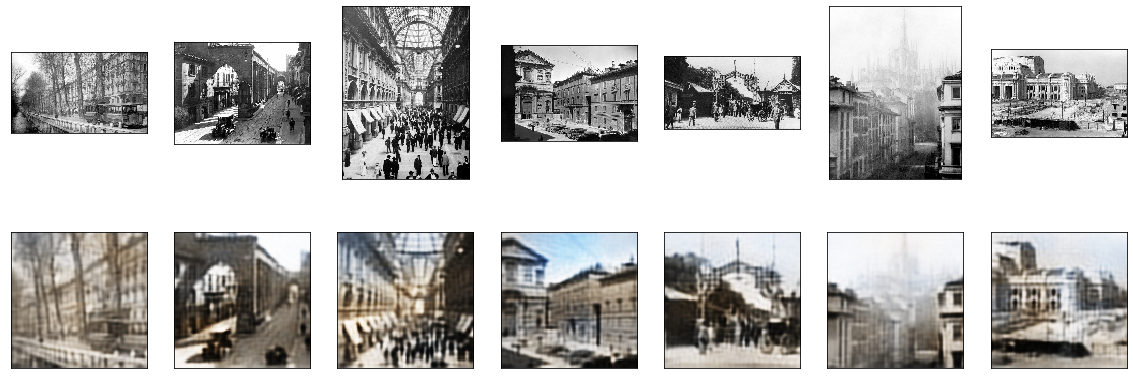

In [15]:
n = 7  # how many digits we will display
plt.figure(figsize=(20, 7))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(imgs_bw[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(imgs_colored[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig('results_ae.png',dpi=300, bbox_inches='tight')
plt.show()

#### 299x299 autoencoder

In [6]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        #Encoding layers
        self.conv1 = nn.Conv2d(1, 32, (5,5), stride=2, padding=1)  #out 16x149x149
        self.conv2 = nn.Conv2d(32, 64, (5,5), stride=2, padding=1) #out 64x74x74
        self.conv3 = nn.Conv2d(64, 128, (4,4), stride=2, padding=0) #out 128x36x36
        self.conv4 = nn.Conv2d(128, 512, (4,4), stride=2, padding=1) #out 512x18x18
        self.conv5 = nn.Conv2d(512, 1024, (4,4), stride=2, padding=1) #out 1024x9x9
        
        #Decoding layers
        self.deconv1 = nn.ConvTranspose2d(1024, 512, (4,4), stride=2, padding=1) #512x18x18
        self.deconv2 = nn.ConvTranspose2d(512, 128, (4,4), stride=2, padding=1)  #128x36x36
        self.deconv3 = nn.ConvTranspose2d(128, 64, (4,4), stride=2, padding=0)   #64x74x74
        self.deconv4 = nn.ConvTranspose2d(64, 32, (5,5), stride=2, padding=1)    #32x149x149
        self.deconv5 = nn.ConvTranspose2d(32, 3, (5,5), stride=2, padding=1)     #3x299x299
        
        #GDN linear activation
        self.gdn1 = GDN(32)
        self.gdn2 = GDN(64)
        self.gdn3 = GDN(128)
        self.gdn4 = GDN(512)
        self.gdn5 = GDN(1024)
        self.gdn_1 = GDN(512, inverse=True)
        self.gdn_2 = GDN(128, inverse=True)
        self.gdn_3 = GDN(64, inverse=True)
        self.gdn_4 = GDN(32, inverse=True)
        
    def Encoder(self, x):
        x = self.gdn1(self.conv1(x))
        x = self.gdn2(self.conv2(x))
        x = self.gdn3(self.conv3(x))
        x = self.gdn4(self.conv4(x))
        z = self.gdn5(self.conv5(x))
        return z
    
    def Decoder(self, z):
        x = self.gdn_1(self.deconv1(z))
        x = self.gdn_2(self.deconv2(x))
        x = self.gdn_3(self.deconv3(x))
        x = self.gdn_4(self.deconv4(x))
        out = F.sigmoid(self.deconv5(x))
        return out

    def forward(self, x):
        z = self.Encoder(x)
        out = self.Decoder(z)
        return out

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
autoencoder = AutoEncoder()
autoencoder.load_state_dict(torch.load('AE299x299_weights.pth'))
autoencoder.eval()
autoencoder = autoencoder.to(device)

In [8]:
preprocess = transforms.Compose([transforms.Resize(299),
                                 transforms.CenterCrop(299),
                                 transforms.ToTensor()])
gray_1ch = transforms.Grayscale(num_output_channels=1)

In [9]:
imgs_bw = []
imgs_colored = []
for imgs in os.listdir(path):
    im = Image.open(path+'/'+imgs)
    im_gray = gray_1ch(im)
    imgs_bw.append(np.asarray(im_gray))
    im_colored = process_img(im_gray)
    imgs_colored.append(im_colored)

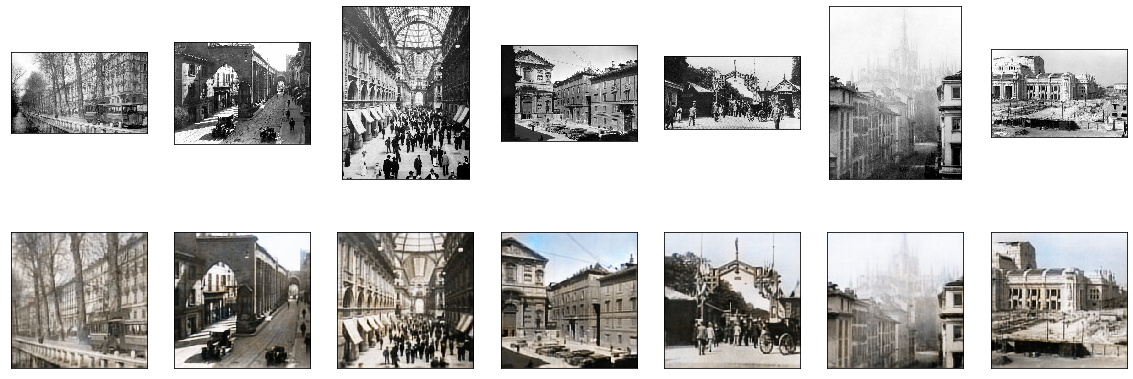

In [8]:
imgs_colored = np.stack(imgs_colored, axis=0)
imgs_colored = imgs_colored.reshape(7,3,299,299)
imgs_colored = np.transpose(imgs_colored, (0,2,3,1))
n = 7  # how many digits we will display
plt.figure(figsize=(20, 7))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(imgs_bw[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(imgs_colored[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig('results_ae299x299.png',dpi=300, bbox_inches='tight')
plt.show()

#### 299x299 more trained

In [9]:
autoencoder = AutoEncoder()
autoencoder.load_state_dict(torch.load('AE299x299_weights_2.pth'))
autoencoder.eval()
autoencoder = autoencoder.to(device)

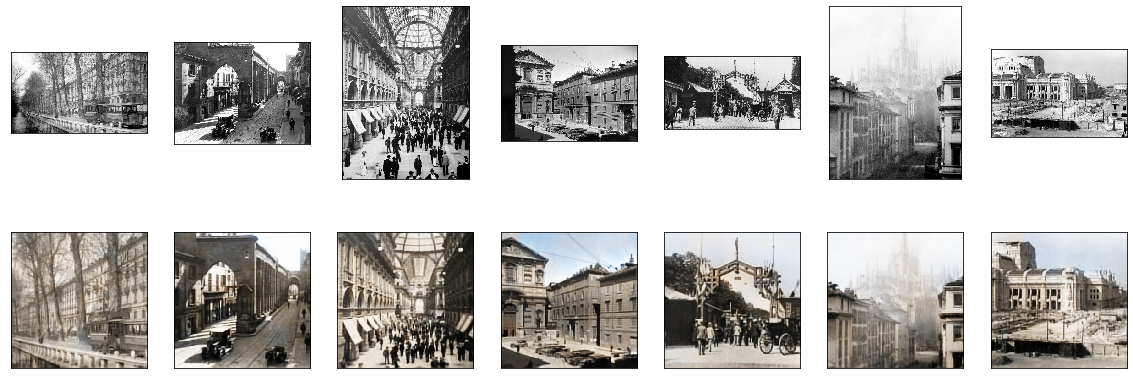

In [10]:
imgs_bw = []
imgs_colored = []
for imgs in os.listdir(path):
    im = Image.open(path+'/'+imgs)
    im_gray = gray_1ch(im)
    imgs_bw.append(np.asarray(im_gray))
    im_colored = process_img(im_gray)
    imgs_colored.append(im_colored)
imgs_colored = np.stack(imgs_colored, axis=0)
imgs_colored = imgs_colored.reshape(7,3,299,299)
imgs_colored = np.transpose(imgs_colored, (0,2,3,1))
n = 7  # how many digits we will display
plt.figure(figsize=(20, 7))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(imgs_bw[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(imgs_colored[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig('results_ae299x299_trainedmore.png',dpi=300, bbox_inches='tight')
plt.show()

### trained more more more

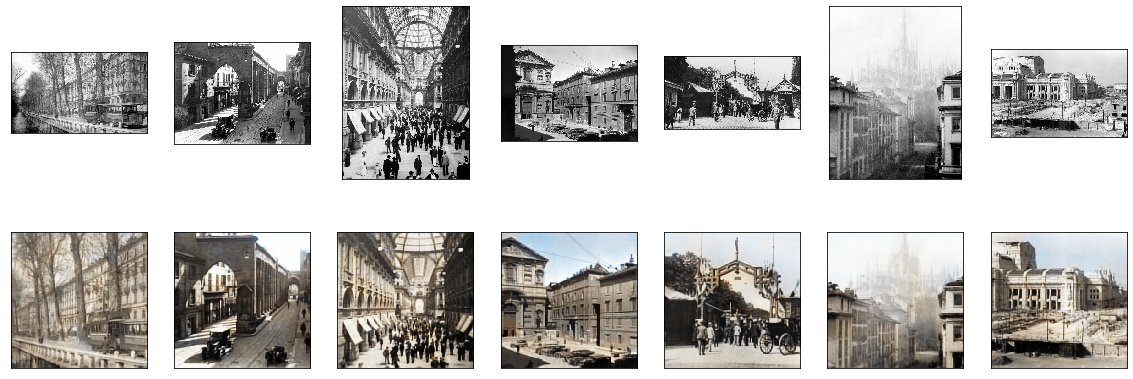

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
autoencoder = AutoEncoder()
autoencoder.load_state_dict(torch.load('AE299x299_weights_3.pth'))
autoencoder.eval()
autoencoder = autoencoder.to(device)
imgs_bw = []
imgs_colored = []
for imgs in os.listdir(path):
    im = Image.open(path+'/'+imgs)
    im_gray = gray_1ch(im)
    imgs_bw.append(np.asarray(im_gray))
    im_colored = process_img(im_gray)
    imgs_colored.append(im_colored)
imgs_colored = np.stack(imgs_colored, axis=0)
imgs_colored = imgs_colored.reshape(7,3,299,299)
imgs_colored = np.transpose(imgs_colored, (0,2,3,1))
n = 7  # how many digits we will display
plt.figure(figsize=(20, 7))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(imgs_bw[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(imgs_colored[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig('results_ae299x299_trainedmore2.png',dpi=300, bbox_inches='tight')
plt.show()